# Rule: **base_network**

**Summary**

Creates the network topology from a ENTSO-E map extract as a PyPSA network.

**Outputs:**

- resources/networks/`base.nc`
- resources/regions_onshore
- resources/regions_offshore


**Comments:**

In [9]:
import pypsa
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os 
import sys


##### Local funs
funs_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'local_funs'))
sys.path.append(funs_path)

from fun_map_add_features import fun_map_add_features
from fun_map_network_geometry import fun_map_network_geometry


##### Warnings setup
import warnings
warnings.filterwarnings('ignore', category=UserWarning)



In [10]:
######################################## Parameters

rootpath = '/home/aerolinux3/clouds_and_repos/git/pypsa-spain/'
prefix = 'Voronoi_only_where_loads'
name = 'false'

boundaries= [-14, 6.35, 35, 46.3]

## `base.nc`

In [11]:
file = f'base.nc'
path = f'{rootpath}/resources/{prefix}/{name}/networks/'

n = pypsa.Network(path+file)

n


INFO:pypsa.io:Imported network base.nc has buses, carriers, lines, links, shapes, transformers


PyPSA Network 'PyPSA-Spain'
Components:
 - Bus: 1109
 - Carrier: 2
 - Line: 1474
 - Link: 1
 - Shape: 1100
 - Transformer: 84
Snapshots: 8760

Text(0.5, 1.0, 'base.nc')

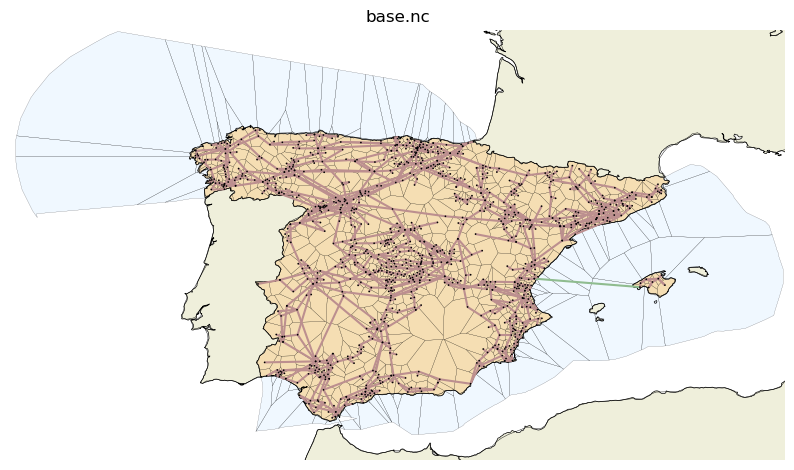

In [12]:
########## Plot the network

bus_sizes = 0.0005
bus_colors = 'black'


fig_size = [10,16]
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=fig_size, subplot_kw={'projection': crs})


### Add features
fun_map_add_features(ax)

### Add network geometry
fun_map_network_geometry(n, ax)

### Add network
n.plot(ax=ax, bus_sizes=bus_sizes, bus_colors=bus_colors, boundaries=boundaries)


ax.set_title('base.nc')




### Variable: `n.buses`

Buses are classified into *Substation*, *joint* and others according to column `symbol`. 

In [13]:
n.buses['symbol'].value_counts(normalize=True)*100

symbol
Substation                    59.963931
joint                         39.855726
Other or not listed            0.090171
Substations + Power Plants     0.090171
Name: proportion, dtype: float64

### Variable: `n.carriers`

In [14]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
AC,0.0,,,inf,0.0
DC,0.0,,,inf,0.0


### Variable: `n.lines`

Distribution of line lengths.

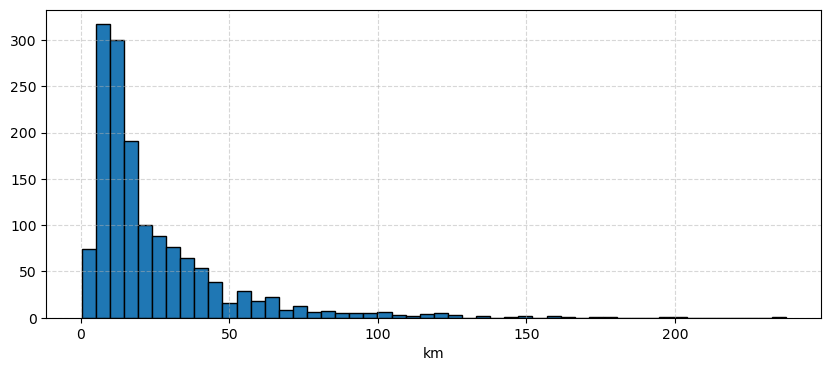

In [15]:
bins = 50


fig_size = [10,4]

fig, ax = plt.subplots(figsize=fig_size)


ax.hist(n.lines['length'], bins=bins, edgecolor='black')

ax.set_xlabel('km')
ax.grid(True, linestyle='--', alpha=0.5)


### Variable: `n.links`

In [16]:
n.links

,bus0,bus1,length,underground,under_construction,tags,geometry,carrier,p_min_pu,p_nom,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
5640,1422,1638,234.733219,False,False,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""32590"", ""...","LINESTRING(2.48932993486183 39.561252379133,1....",DC,-1.0,400.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


## `regions_onshore.geojson` , `regions_offshore.geojson`

Contains onshore and offshore regions information stored in `n.shapes`.